In [43]:
#data associated with the publication: Fano Resonant Optical coatings platform for Full Gamut and High Purity Structural Colors
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.path as mplpath
import h5py
import scipy.spatial as spsp
#not strictly necessary
from joblib import Parallel, delayed
import multiprocessing
cores = multiprocessing.cpu_count()

#wavelength range in visible [nm]
LDAS = np.arange(380, 781, 1)
#angular range [deg]
angles = np.arange(0,86,1)

#spectra of the D65 illuminant
D65_DATA = np.array([0.0341, 1.6643, 3.2945, 11.7652, 20.236, 28.6447, 37.0535, 38.5011, 39.9488, 42.4302, 44.9117, 45.775, 46.6383, 49.3637, 52.0891, 51.0323, 49.9755, 52.3118, 54.6482, 68.7015, 82.7549, 87.1204, 91.486, 92.4589, 93.4318, 90.057, 86.6823, 95.7736, 104.865, 110.936, 117.008, 117.41, 117.812, 116.336, 114.861, 115.392, 115.923, 112.367, 108.811, 109.082, 109.354, 108.578, 107.802, 106.296, 104.79, 106.239, 107.689, 106.047, 104.405, 104.225, 104.046, 102.023, 100, 98.1671, 96.3342, 96.0611, 95.788, 92.2368, 88.6856, 89.3459, 90.0062, 89.8026, 89.5991, 88.6489, 87.6987, 85.4936, 83.2886, 83.4939, 83.6992, 81.863, 80.0268, 80.1207, 80.2146, 81.2462, 82.2778, 80.281, 78.2842, 74.0027, 69.7213, 70.6652, 71.6091, 72.979, 74.349, 67.9765, 61.604, 65.7448, 69.8856, 72.4863, 75.087, 69.3398, 63.5927, 55.0054, 46.4182, 56.6118, 66.8054, 65.0941, 63.3828, 63.8434, 64.304, 61.8779, 59.4519, 55.7054, 51.959, 54.6998, 57.4406, 58.8765, 60.3125])
D65 = np.array([np.interp(lda, np.arange(300, 831, 5), D65_DATA) for lda in LDAS])
wp = XYZ_to_xy(get_XYZ(D65))

#import the file with the standard observer distributions (see manuscript)
CMF = pd.read_csv("2012_XYZ.csv", header=None, names=["lda", "xbar", "ybar", "zbar"])

#XZY individual distribution interpolations
xbar = np.array([np.interp(lda, CMF["lda"], CMF["xbar"]) for lda in LDAS])
ybar = np.array([np.interp(lda, CMF["lda"], CMF["ybar"]) for lda in LDAS])
zbar = np.array([np.interp(lda, CMF["lda"], CMF["zbar"]) for lda in LDAS])

#XYZ of the white point
D65_XYZ = (np.sum(D65 * xbar), np.sum(D65 * ybar), np.sum(D65 * zbar))
N = np.sum(D65 * ybar) / 100

#return the XYZ coordinates from a spectral wavelength distribution
#use LDAS for the wavelengths!
def get_XYZ(spec):
    return (np.sum(spec * D65 * xbar) / N, np.sum(spec * D65 * ybar) / N, np.sum(spec * D65 * zbar) / N)

#############
#Conversions#
#############

#convert XYZ to RGB coordinates
def XYZ_to_RGB(XYZ):
    X, Y, Z = XYZ 
    X /= 100
    Y /= 100
    Z /= 100
    #transformation matrix
    M = np.array([[3.24096994, -1.53738318, -0.49861076], [-0.96924364, 1.8759675, 0.04155506], [0.05563008, -0.20397696, 1.05697151]])
    RGB = np.dot(M, [X, Y, Z])
    for i in range(3):
        if RGB[i] < 0.0031308:
            RGB[i] = 12.92 * RGB[i]
        else:
            RGB[i] = 1.055 * np.power(RGB[i], 1 / 2.4) - 0.055
    RGB *= 255
    RGB = np.clip(RGB, 0, 255)
    return tuple(RGB)

#convert RGB to XYZ coordinates
def RGB_to_XYZ(RGB):
    RGB /= 255
    for i in range(3):
        if RGB[i]/12.92 < 0.0031308:
            RGB[i] /= 12.92
        else:
            RGB[i] = np.power((RGB[i] + 0.055)/1.055, 2.4)
    R,G,B = RGB
    M = np.array([[3.24096994, -1.53738318, -0.49861076], [-0.96924364, 1.8759675, 0.04155506], [0.05563008, -0.20397696, 1.05697151]])
    MM = np.linalg.inv(M)
    XYZ = np.dot(M, [R, G, B])*100
    xy = XYZ_to_xy(XYZ)
    return xy
    
#convert XYZ to xy coordinates (CIE 1931)
def XYZ_to_xy(XYZ):
    X, Y, Z = XYZ
    x = X / (X + Y + Z)
    y = Y / (X + Y + Z)
    return (x, y)

#convert xy to xyY coordinates
def xy_to_xyY(xy, Y=90):
    return (xy[0], xy[1], Y)

#convert xy to XYZ coordinates (full brightness)
def xy_to_XYZ(xy):
    x, y, Y = xy_to_xyY(xy)
    return (Y * x / y, Y, Y / y * (1 - x - y))

#convert xy to RGB coordinates (full brightness)
def xy_to_RGB(xy):
    return XYZ_to_RGB(xy_to_XYZ(xy))


#calculate the points along the outside of the gamut
pure_x = xbar[56:321] / (xbar[56:321] + ybar[56:321] + zbar[56:321])
pure_y = ybar[56:321] / (xbar[56:321] + ybar[56:321] + zbar[56:321])
#purple line
purple_x = pure_x[-1] + np.linspace(0, 1, 265) * (pure_x[0] - pure_x[-1])
purple_y = pure_y[-1] + np.linspace(0, 1, 265) * (pure_y[0] - pure_y[-1])
CIE_x = np.concatenate((pure_x, purple_x))
CIE_y = np.concatenate((pure_y, purple_y))
CIE_xy = [(x, y) for x, y in zip(CIE_x, CIE_y)]
path = mplpath.Path(CIE_xy)

#color gamut generation
def generate_chromaticity_diagram():
    diagram = np.ones((400, 450, 3), dtype=np.uint8) * 255
    print("Generating Chromaticity Diagram")
    for i,x in tqdm(enumerate(np.linspace(0,0.8,400))):
        for j,y in enumerate(np.linspace(0,0.9,450)):
            xy = (x,y)
            if path.contains_point(xy):
                RGB = xy_to_RGB(xy)
                diagram[i, j] = RGB
    print("Generation Complete!")
    return diagram

#diagram is global
diagram = np.ones((400, 450, 3), dtype=np.uint8) * 255
is_diagram_drawn = False #redraw the gamut

#plot the xy points on a CIE color gamut
def draw_on_diagram(xys, ax, color, label, wp=True):
    global is_diagram_drawn
    global diagram
    #only generate gamut if not already done
    if not is_diagram_drawn:
        diagram = generate_chromaticity_diagram()
        is_diagram_drawn = True
    ax.imshow(np.rot90(diagram), extent=[0, 0.8, 0, 0.9], aspect='auto')
    ax.plot(CIE_x, CIE_y)#plot the outer extents of the gamut
    ax.set_xlim([0, 0.8])
    ax.set_ylim([0, 0.9])
    xs = [xy[0] for xy in xys]
    ys = [xy[1] for xy in xys]
    ax.scatter(xs, ys, s=1, c=color, marker = 'o',lw=4, label=label)
    #flag for including a dot at the white point
    if wp:
        D65_xy = XYZ_to_xy(D65_XYZ)
        ax.scatter(D65_xy[0], D65_xy[1], marker = 'o', color='black')

#distance between two points in xy space
def xy_colorspace_distance(xy_gen,xy_target):
    xd = xy_gen[0]-xy_target[0]
    yd = xy_gen[1]-xy_target[1]
    distance = np.sqrt(np.square(xd)+np.square(yd))
    return distance
        
    
#calculate the purity

#helper
def d_point_to_ray(p, a, b):
    B = np.array(a)
    M = np.array(b) - np.array(a)
    P = np.array(p)
    t = np.dot(M, P - B) / np.dot(M, M)
    if t > 0:
        return np.linalg.norm(P - B)
    else:
        return np.linalg.norm(P - (B + t * M))
#returns CIE point (outside of gmaut) of dominant color response
def get_dominant_wavelength_point(p, wp=XYZ_to_xy(D65_XYZ)):
    if not path.contains_point(p):
        return 0
    minfunc = [d_point_to_ray(pure_xy, p, wp) for pure_xy in CIE_xy]
    return CIE_xy[np.argmin(minfunc)]

#main purity callable
#calculate purity for a single xy point
def get_purity_info(p, wp=XYZ_to_xy(D65_XYZ)):
    #dominant wavelength point
    xd, yd = get_dominant_wavelength_point(p, wp)
    #excitation
    ep = np.linalg.norm(np.array(p) - np.array(wp)) / np.linalg.norm(np.array(wp) - np.array([xd, yd]))
    #colorimetric
    cp = yd * ep / p[1]
    return ep, cp, (xd, yd)
    
    
#calculate the area coverage

def xyCoverageArea(xy_data):
    xy_data = np.array(xy_data)
    
    #calculate area
    def area(data):
        x = data[:,0]
        y = data[:,1]
        return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
    
    #using a convex hull for the provided xy points
    #smallest convex set containing the points (think of streching a rubber band)
    hull = spsp.ConvexHull(xy_data)
    
    #find the area in xy space
    edgepts = xy_data[hull.vertices,:]
    coverage = area(edgepts)
    fedge = edgepts #points around the edge of the hull
    
    #find the area of the entire gamut
    wp=XYZ_to_xy(D65_XYZ)
    theta = np.linspace(0,2*np.pi,200)
    x = 0.1*np.cos(theta)+wp[0]
    y = 0.1*np.sin(theta)+wp[1]
    edgePts = np.zeros((200,2))
    for i in range(200):
        edgePts[i,:] = get_dominant_wavelength_point([x[i],y[i]], wp)
    hullEdge = spsp.ConvexHull(edgePts)
    edge = edgePts[hullEdge.vertices,:]
    coverageEdge = area(edge)
    
    #fractional coverage of the visible gamut
    cover = coverage/coverageEdge
    return cover, fedge

#verticies for the sRGB and adobe RGB color spaces
sRGB = np.array([[0.64,0.33],[0.3,0.6],[0.15,0.06]])
adobeRGB = np.array([[0.64,0.33],[0.21,0.71],[0.15,0.06]])

In [11]:
#tmm based simulation of FROCs

import TMM_numba as tmm
import BB_metals as bb
import dielectric_materials as di
from tqdm.auto import tqdm

wave = LDAS*1E-9
#superstrate
sup = np.ones_like(wave,dtype=np.complex128)
#substrate
sub = np.ones_like(wave,dtype=np.complex128)
#materials imported from the Brendel-Bormann model
ag = bb.nk_material('Ag',wave)
cr = bb.nk_material('Cr',wave)
al = bb.nk_material('Al',wave)
ni = bb.nk_material('Ni',wave)
pt = bb.nk_material('Pt',wave)

#materials imported from external models and RefractiveIndex.info
#Ge
gen = np.loadtxt('nGe.txt')
gek = np.loadtxt('kGe.txt')
ge = np.interp(wave,np.arange(300,1001)*1E-9,gen-1j*gek)#- is not an error
#SiO2 and TiO2
const = np.loadtxt('constants.csv',delimiter=',',skiprows=1)
sio2 = np.interp(wave,const[:,0]*1E-9,const[:,1]+1j*const[:,2])
tio2 = np.interp(wave,const[:,6]*1E-9,const[:,7]+1j*const[:,8])
#Wo3
wo3d = np.loadtxt('WO3.csv',delimiter=',',skiprows=1)
wo3 = np.interp(wave,wo3d[:,0]*1E-6,wo3d[:,1]+1j*wo3d[:,2])
#Al2O3
wo3d = np.loadtxt('Al2O3.csv',delimiter=',',skiprows=1)
al2o3 = np.interp(wave,wo3d[:,0]*1E-6,wo3d[:,1]+1j*0)
#TiN
wo3d = np.loadtxt('TiN.csv',delimiter=',',skiprows=1)
tin = np.interp(wave,wo3d[:,0]*1E-6,wo3d[:,1]+1j*wo3d[:,2])
#MoO3
wo3d = np.loadtxt('WO3.csv',delimiter=',',skiprows=1)
moo3 = np.interp(wave,wo3d[:,0]*1E-6,wo3d[:,1]+1j*wo3d[:,2])
#a-Si
asin = np.loadtxt('asi-n.csv',delimiter=',')
asin = np.interp(wave,asin[:,0]*1E-9,asin[:,1])
asik = np.loadtxt('asi-k.csv',delimiter=',')
asik = np.interp(wave,asik[:,0]*1E-9,asik[:,1])
asi = asin+1j*asik
#Si Aspnes
sid = np.loadtxt('siAspnes.csv',delimiter=',')
si = np.interp(wave,sid[:,0]*1E-6,sid[:,1]+1j*sid[:,2])
#LiF
lifd = np.loadtxt('LiF.csv',delimiter=',',skiprows=1)
lif = np.interp(wave,lifd[:,0]*1E-6,lifd[:,1]+1j*0)
#Bi
lifd = np.loadtxt('Bi.csv',delimiter=',',skiprows=1)
bi = np.interp(wave,lifd[:,0]*1E-6,lifd[:,1]+1j*lifd[:,2])
#SiN (Sellmeier Model)
sin = np.sqrt(1+(2.8939*(wave*1E6)**2)/((wave*1E6)**2-0.13967**2))+0*1j

#cauchy model with constant k
def cauchy(wave,a,b,k=0):
    n = a + 1E-12*b/wave**2
    return n+1j*k

## Simulate FROC and calculate properties

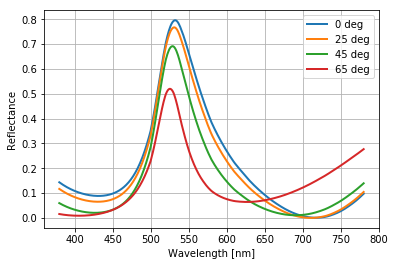

In [47]:
#simulate a FROC

#materials in order top --> bottom
n = np.array([ge,ag,tio2,ag])
#thicknesses in same order as materials
l = np.array([15,24,75,100])*1E-9
#angle of incidence (deg)
for ang in [0,25,45,65]:
    rp = np.zeros(wave.size)
    for i in range(wave.size):
        #usage: tmm.reflect_amp(polarization (1=p,0=s), aoi, wavelength, n, l, superst., subst.)
        rp[i] = tmm.reflect_amp(1, ang, wave[i], n[:,i], l, 1.+1j*0, 1.+1j*0)
    plt.plot(wave*1E9,rp,'-',lw=2,label=str(ang)+' deg')
    
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflectance')
plt.legend()
plt.grid()
plt.show()

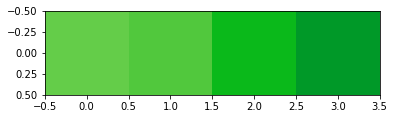

In [48]:
#Look at color response

#note that color must be uint8 for this to work
RGB = np.zeros((1,4,3),dtype=np.uint8)

#materials in order top --> bottom
n = np.array([ge,ag,tio2,ag])
#thicknesses in same order as materials
l = np.array([15,24,75,100])*1E-9
#angle of incidence (deg)
for j,ang in enumerate([0,25,45,65]):
    rp = np.zeros(wave.size)
    for i in range(wave.size):
        #usage: tmm.reflect_amp(polarization (1=p,0=s), aoi, wavelength, n, l, superst., subst.)
        rp[i] = tmm.reflect_amp(1, ang, wave[i], n[:,i], l, 1.+1j*0, 1.+1j*0)
    XYZ = get_XYZ(rp)
    #convert to RGB
    RGB[:,j,:] = XYZ_to_RGB(XYZ)

plt.imshow(RGB)
plt.show()

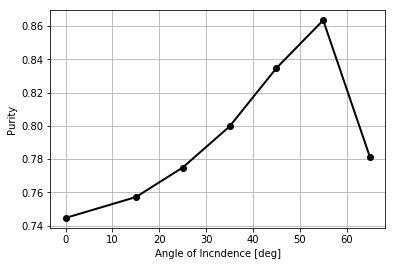

In [74]:
#Look at purity

purities = np.zeros(7)

#materials in order top --> bottom
n = np.array([ge,ag,tio2,ag])
#thicknesses in same order as materials
l = np.array([15,24,75,100])*1E-9
#angle of incidence (deg)
for j,ang in enumerate([0,15,25,35,45,55,65]):
    rp = np.zeros(wave.size)
    for i in range(wave.size):
        #usage: tmm.reflect_amp(polarization (1=p,0=s), aoi, wavelength, n, l, superst., subst.)
        rp[i] = tmm.reflect_amp(1, ang, wave[i], n[:,i], l, 1.+1j*0, 1.+1j*0)
    XYZ = get_XYZ(rp)
    xy = XYZ_to_xy(XYZ)
    #purity info
    _,p,_ = get_purity_info(xy,wp)
    purities[j] = p
    
plt.plot([0,15,25,35,45,55,65],purities,'ko-',lw=2)
plt.xlabel('Angle of Incndence [deg]')
plt.ylabel('Purity')
plt.grid()
plt.show()

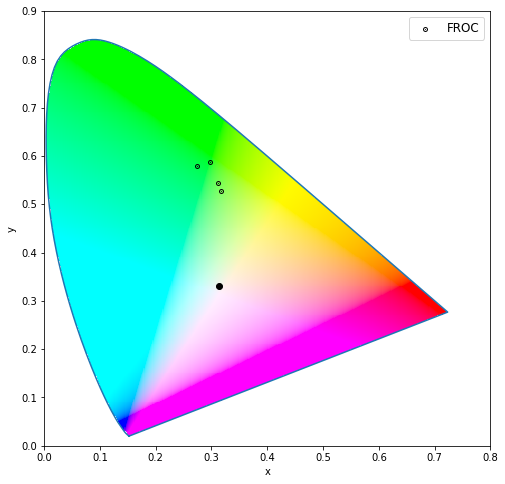

In [52]:
#Plot on the Gamut

xys=[]

#materials in order top --> bottom
n = np.array([ge,ag,tio2,ag])
#thicknesses in same order as materials
l = np.array([15,24,75,100])*1E-9
#angle of incidence (deg)
for j,ang in enumerate([0,25,45,65]):
    rp = np.zeros(wave.size)
    for i in range(wave.size):
        #usage: tmm.reflect_amp(polarization (1=p,0=s), aoi, wavelength, n, l, superst., subst.)
        rp[i] = tmm.reflect_amp(1, ang, wave[i], n[:,i], l, 1.+1j*0, 1.+1j*0)
    XYZ = get_XYZ(rp)
    xy = XYZ_to_xy(XYZ)
    xys.append(xy)
    

#plot on the gamut
#note that colors may not look the same as RGB due to rendering of gamut
fig,ax1 = plt.subplots(1,1,figsize=(8,8))
draw_on_diagram(xys,ax1,'k','FROC')
ax1.legend(fontsize=12)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
# plt.savefig('gamut.png',dpi=300)
plt.show()

Fractional gamut coverage: 0.59


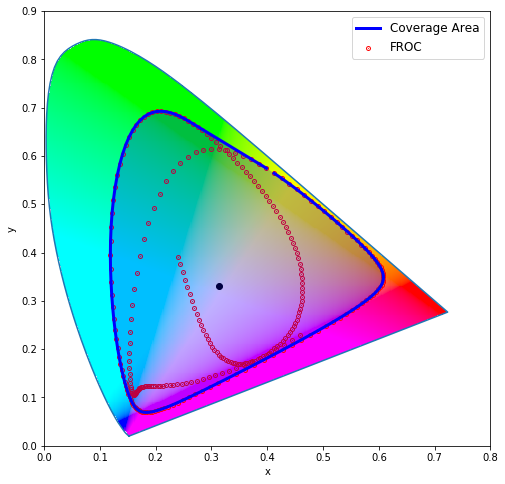

In [61]:
#look at coverage area

xys = []

#angle of incidence (deg)
ang=55
#loop over cavity thicknesses
for j,k in enumerate(np.arange(0,300)):
    #materials in order top --> bottom
    n = np.array([ge,ag,tio2,ag])
    #thicknesses in same order as materials
    l = np.array([15,24,k,100])*1E-9
    rp = np.zeros(wave.size)
    for i in range(wave.size):
        #usage: tmm.reflect_amp(polarization (1=p,0=s), aoi, wavelength, n, l, superst., subst.)
        rp[i] = tmm.reflect_amp(1, ang, wave[i], n[:,i], l, 1.+1j*0, 1.+1j*0)
    XYZ = get_XYZ(rp)
    xy = XYZ_to_xy(XYZ)
    xys.append(xy)

#look at the coverage area
coverage,d = xyCoverageArea(xys)
print('Fractional gamut coverage: %2.2f'%(coverage))

#plot everything on the gamut
fig,ax1 = plt.subplots(1,1,figsize=(8,8))
draw_on_diagram(xys,ax1,'r','FROC')
ax1.fill(d[:,0],d[:,1],'b',alpha=0.25)
ax1.plot(d[:,0],d[:,1],'b',lw=3,label='Coverage Area')
ax1.legend(fontsize=12)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
# plt.savefig('gamut.png',dpi=300)
plt.show()

## Generate Irridesence Plots

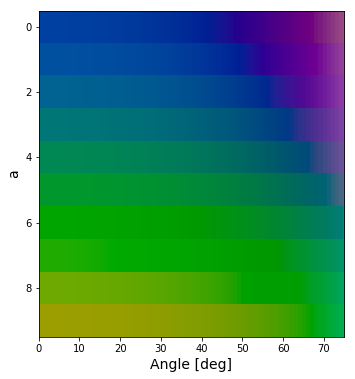

In [72]:
angles = np.arange(0,76,1) #range of angles

#calculate the color for given cauchy paraemters
#a=n, b=k=0 is a constant (dispersionless) index of refraction
def calc_spec(a,b,k,thick):
    #thickness variable
    l = np.array([50,15,24,thick,100])*1E-9
    #recalculate the material
    mat = cauchy(wave,a,b,k)
    n = np.array([sio2,ge,ag,mat,ag])
    colors = np.ones((1,angles.size,3),dtype=np.uint8)*255
    for j in range(angles.size):
        rp = np.zeros(wave.size)
        for i in range(wave.size):
            rp[i] = tmm.reflect_amp(1, angles[j], wave[i], n[:,i], l, 1.+1j*0, 1.+1j*0)
        XYZ = get_XYZ(rp)
        rgb = XYZ_to_RGB(XYZ)
        colors[0,j,:] = rgb
    return colors

#a values in cauchy
a = np.linspace(3.0,4.0,10)
colall = np.ones((a.size,angles.size,3),dtype=np.uint8)*255
#loop over a values
for k in range(a.size):
    thick = 100 #nm
    #b=0.025 (dispersion) k=0
    colall[k,:,:] = calc_spec(a[k],0.025,0,thick)
    
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(colall, aspect=8)
ax.set_xlim([0,75])
ax.set_ylabel('a',fontsize=14)
ax.set_xlabel('Angle [deg]',fontsize=14)
plt.show()

## Optimization

In [19]:
#loss functions
def Froc(x,ang,target):
    n = np.array([ge,ag,tio2,ag])
    l = np.array([x[0],x[1],x[2],100])*1E-9
    rp = np.zeros(wave.size)
    for i in range(wave.size):
        rp[i] = tmm.reflect_amp(1, ang, wave[i], n[:,i], l, 1.+1j*0, 1.+1j*0)
    XYZ = get_XYZ(rp)
    xy = XYZ_to_xy(XYZ)
    #optimizes w.r.t. distance in xy space
    dist = xy_colorspace_distance(xy,target)
    return dist

def SiCapFroc(x,ang,target):
    n = np.array([sio2,ge,ag,tio2,ag])
    l = np.array([50,x[0],x[1],x[2],100])*1E-9
    rp = np.zeros(wave.size)
    for i in range(wave.size):
        rp[i] = tmm.reflect_amp(1, ang, wave[i], n[:,i], l, 1.+1j*0, 1.+1j*0)
    XYZ = get_XYZ(rp)
    xy = XYZ_to_xy(XYZ)
    #optimizes w.r.t. distance in xy space
    dist = xy_colorspace_distance(xy,target)
    return dist

#evaluation functions
def Froc_xy(x,ang):
    n = np.array([ge,ag,tio2,ag])
    l = np.array([x[0],x[1],x[2],100])*1E-9
    rp = np.zeros(wave.size)
    for i in range(wave.size):
        rp[i] = tmm.reflect_amp(1, ang, wave[i], n[:,i], l, 1.+1j*0, 1.+1j*0)
    XYZ = get_XYZ(rp)
    xy = XYZ_to_xy(XYZ)
    return xy

def SiCapFroc_xy(x,ang):
    n = np.array([sio2,ge,ag,tio2,ag])
    l = np.array([50,x[0],x[1],x[2],100])*1E-9
    rp = np.zeros(wave.size)
    for i in range(wave.size):
        rp[i] = tmm.reflect_amp(1, ang, wave[i], n[:,i], l, 1.+1j*0, 1.+1j*0)
    XYZ = get_XYZ(rp)
    xy = XYZ_to_xy(XYZ)
    return xy

In [53]:
from scipy.optimize import least_squares
from joblib import Parallel,delayed

#each layers range for global algorithm to predict starting points
ranges = [30,50,150]
#target points for optimization
evalPts = [(CIE_x[i*3],CIE_y[i*3]) for i in range(0,int(len(CIE_x)/3))]
#optimizing to these points maximizes purity (coverage as well) without
#regards to brightness or other factors. Layers can go to zero thickness as well.

#angle of incidence
ang=0
#number of global points
numGlobal = 5

#global optimization function
def opt(j,ang):
    #single optimization target color
    target = evalPts[j]
    #structure to optimize
    struct = Froc
    size = len(ranges)
    best = 9999999999
    #loop over searches
    for k in range(numGlobal):
        #initial guess is random
        x0 = np.random.uniform(0,1,size=(size,))*ranges
        #use SciPy least squares to optimize the response
        #no layer should exceed 300nm
        plsq = least_squares(struct,x0,bounds=(0,300),args=[ang,target])
        if plsq.cost<best:
            best=plsq.cost
            bestArr = plsq.x
    #return the optimal layer thicknesses for the structure
    return bestArr

#parallelize over the target points with joblib
#originally on HPC cluster, might take longer to finish on a personal computer
result = Parallel(n_jobs=24)(delayed(opt)(j,ang) for j in tqdm(range(len(evalPts))))
result = np.array(result)
np.savetxt('optimization_results.npy',result)

100%|██████████| 176/176 [01:10<00:00,  2.48it/s]


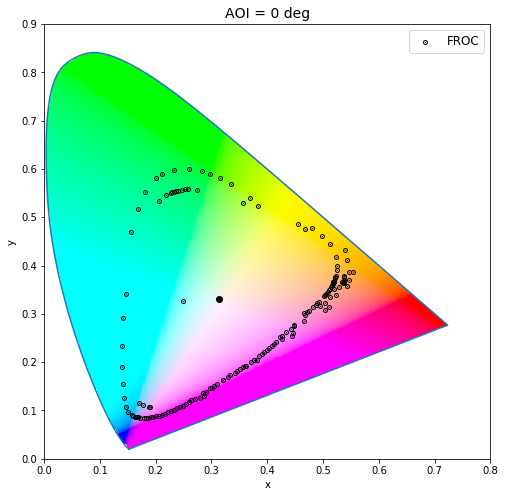

In [75]:
#plot the optimized structures on the gamut
fig,ax1 = plt.subplots(1,1,figsize=(8,8))

ang=0 #angle of incidence
#get the xy points from above
data = np.loadtxt('optimization_results.npy')
xy = [Froc_xy(data[i,:],ang) for i in range(len(evalPts))]

#plot the points on the gamut
draw_on_diagram(xy,ax1,'k','FROC')
ax1.legend(fontsize=12)
ax1.set_title('AOI = %d deg'%(ang),fontsize=14)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
# plt.savefig('gamut.png',dpi=300)
plt.show()